# Airport Classification and Rural Trends Analysis
This notebook:
1. Loads and processes FAA hub classification data.
2. Merges classification into raw airline data.
3. Aggregates trends over time by airport class.
4. Runs OLS regression on rural airport capacity trends.

## Step 1: Classify Airports Using FAA NPIAS Data

In [2]:
import pandas as pd

# Load the Excel file
df = pd.read_excel(
    "../data/raw/ARP-NPIAS-2025-2029-AppendixA.xlsx",
    sheet_name=0,
)
df.columns = [col.strip().replace("\n", " ") for col in df.columns]

# Select and rename necessary columns
df = df[["LocID", "Enplaned (CY23/FY25)", "Hub (FY25)"]]
df.columns = ["airport_code", "enplanements", "hub_code"]

# Clean enplanement numbers
df["enplanements"] = df["enplanements"].astype(str).str.replace(",", "").astype(int)

# Map hub codes to classification
hub_mapping = {"L": "large", "M": "medium", "S": "small", "N": "nonhub"}
df["classification"] = df["hub_code"].map(hub_mapping)


# Infer missing classifications from enplanement thresholds
def infer_hub(n):
    if n >= 18500000:
        return "large"
    elif n >= 3500000:
        return "medium"
    elif n >= 10000:
        return "small"
    else:
        return "nonhub"


df["classification"] = df["classification"].fillna(df["enplanements"].apply(infer_hub))

# Final selection
df_final = df[["airport_code", "classification"]]
df_final.to_csv("../data/processed/classification_airports.csv", index=False)
print("✅ classification_airports.csv saved successfully.")

✅ classification_airports.csv saved successfully.


## Step 2: Merge Classification into Airline Data

In [3]:
# Load files
df = pd.read_csv("../data/raw/raw_airline_data_sorted.csv")
airport_class = pd.read_csv("../data/processed/classification_airports.csv")

# Merge on ORIGIN
airport_class.columns = ["ORIGIN", "origin_class"]
df = df.merge(airport_class, on="ORIGIN", how="left")

# Merge on DEST
airport_class.columns = ["DEST", "dest_class"]
df = df.merge(airport_class, on="DEST", how="left")

# Assign final classification (use ORIGIN-based for now)
df["airport_classification"] = df["origin_class"]

# Save output
df.to_csv("../data/processed/merged_with_classification.csv", index=False)
print("✅ Classification merge complete.")

✅ Classification merge complete.


## Step 3: Aggregate Annual Trends by Airport Classification

In [4]:
df = pd.read_csv("../data/processed/merged_with_classification.csv")

# Drop rows without classification
df = df[df["airport_classification"].notna()]

# Group by year and classification
summary = (
    df.groupby(["YEAR", "airport_classification"])
    .agg(
        total_seats=("T100_SEATS", "sum"),
        total_passengers=("T100_PASSENGERS", "sum"),
        total_db1b_passengers=("DB1B_PASSENGERS", "sum"),
        route_count=("ROUTE_KEY", pd.Series.nunique),
    )
    .reset_index()
)

# Save output
summary.to_csv("../data/processed/rural_trend_summary.csv", index=False)
print("✅ Annual trends aggregated.")

✅ Annual trends aggregated.


## Step 4: OLS Regression on Seat Trends for Rural Airports (Nonhub)

In [5]:
import statsmodels.api as sm

df = pd.read_csv("../data/processed/rural_trend_summary.csv")

# Filter only rural airports
rural_df = df[df["airport_classification"] == "nonhub"]

X = sm.add_constant(rural_df["YEAR"])
y = rural_df["total_seats"]

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            total_seats   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.047
Method:                 Least Squares   F-statistic:                    0.3688
Date:                Fri, 27 Jun 2025   Prob (F-statistic):              0.554
Time:                        15:34:42   Log-Likelihood:                -257.89
No. Observations:                  15   AIC:                             519.8
Df Residuals:                      13   BIC:                             521.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.246e+08   9.17e+08     -0.572      0.5

/Users/snehsuresh/miniconda3/envs/myenv11/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=15 observations were given.
  return hypotest_fun_in(*args, **kwds)


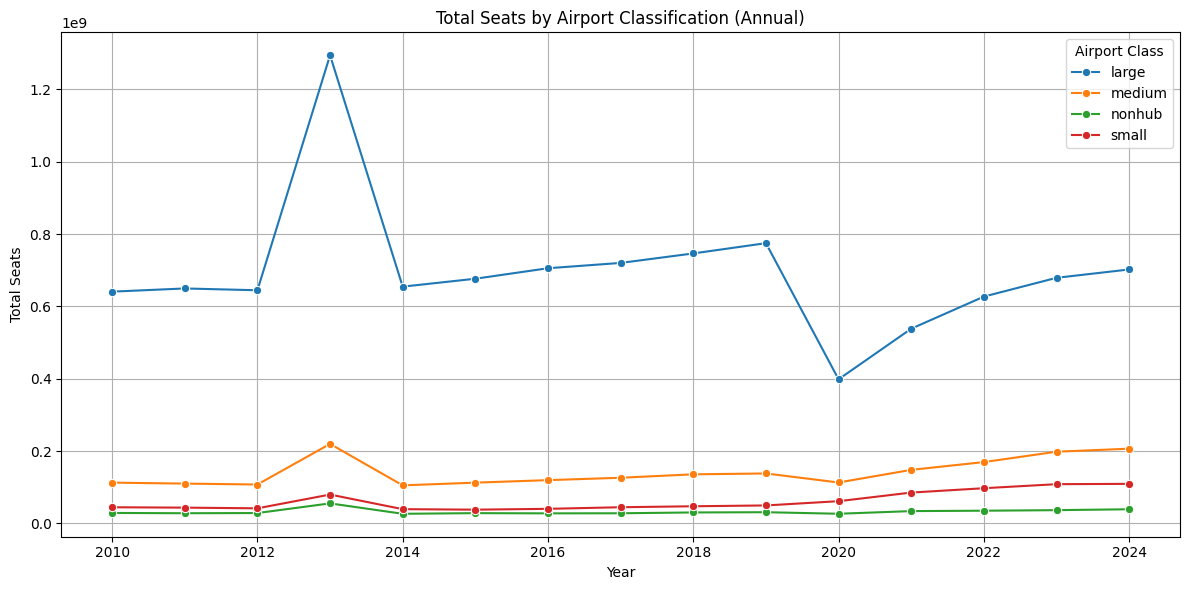

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the summary
df = pd.read_csv("../data/processed/rural_trend_summary.csv")

# Plot total seats over time
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df, x="YEAR", y="total_seats", hue="airport_classification", marker="o"
)

plt.title("Total Seats by Airport Classification (Annual)")
plt.xlabel("Year")
plt.ylabel("Total Seats")
plt.grid(True)
plt.legend(title="Airport Class")
plt.tight_layout()
plt.show()

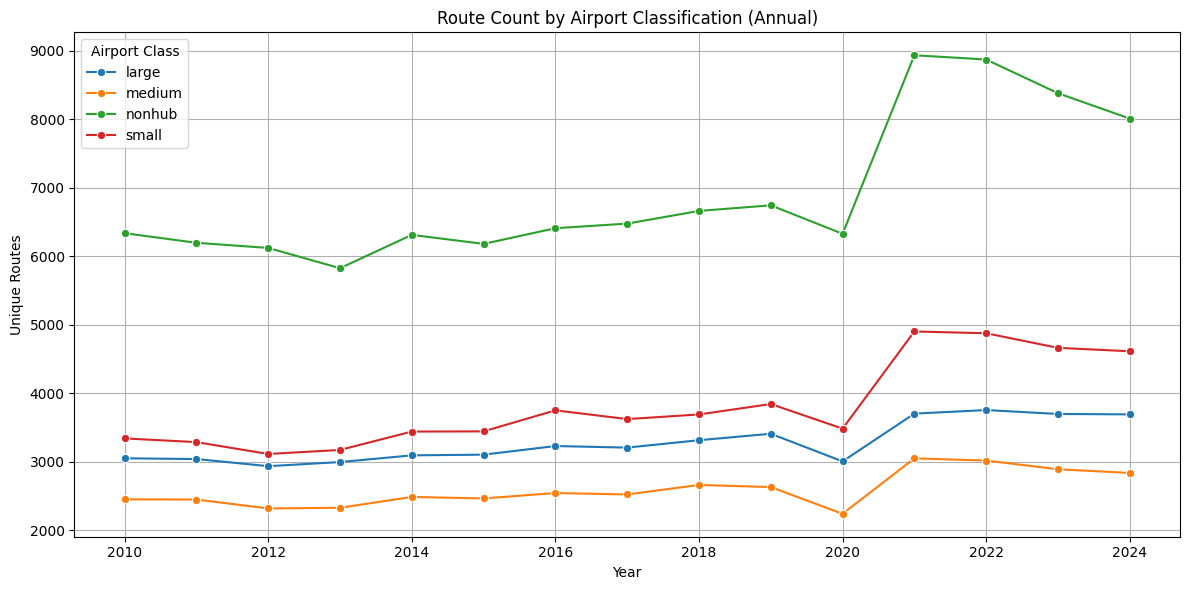

In [7]:
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df, x="YEAR", y="route_count", hue="airport_classification", marker="o"
)

plt.title("Route Count by Airport Classification (Annual)")
plt.xlabel("Year")
plt.ylabel("Unique Routes")
plt.grid(True)
plt.legend(title="Airport Class")
plt.tight_layout()
plt.show()

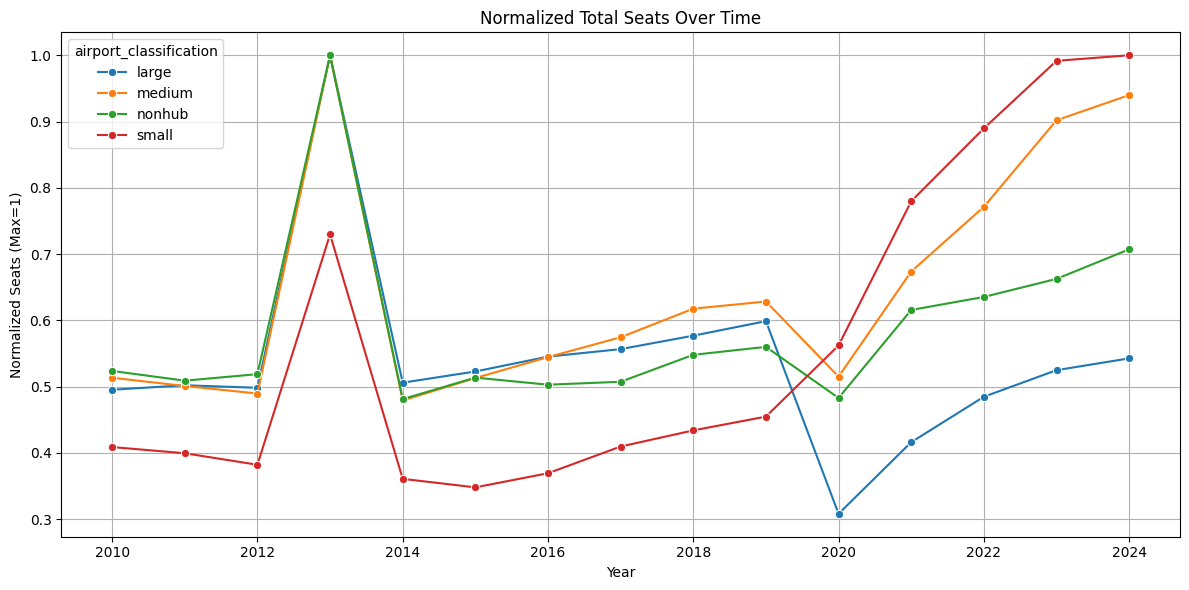

In [8]:
# Normalize within each class
df_norm = df.copy()
df_norm["normalized_seats"] = df_norm.groupby("airport_classification")[
    "total_seats"
].transform(lambda x: x / x.max())

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df_norm,
    x="YEAR",
    y="normalized_seats",
    hue="airport_classification",
    marker="o",
)
plt.title("Normalized Total Seats Over Time")
plt.ylabel("Normalized Seats (Max=1)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Contrary to common narratives: 
1. Rural airport capacity has not significantly declined over time. Instead, the more pressing issue appears to be structural inequality in how seat capacity is distributed across the airport hierarchy.

2. While large, medium, and small airports have seen post-pandemic growth, some dramatically, nonhub airports remain relatively stagnant, not because they’re losing routes, but because they’re not gaining new ones. 

3. This implies a systemic barrier rooted in network design and airline economics rather than a simple time-driven decline